In [1]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler

In [2]:
input_folder = '../data/training_dataset/'
training_data = np.load(input_folder + 'training_data.npy')
valid_periods = np.load(input_folder + 'valid_periods.npy')
categories = np.load(input_folder + 'categories.npy')
print("Training data shape: ", training_data.shape)
print("Valid periods data shape: ", valid_periods.shape)
print("Categories data shape: ", categories.shape)
print("Unique categories: ", np.unique(categories))
print("Example of valid periods: ", valid_periods[1])
print("Sequence lengths: ", valid_periods[:10, 1] - valid_periods[:10, 0])
print("Minimum maximum: ", training_data.min(), training_data.max())

Training data shape:  (48000, 2776)
Valid periods data shape:  (48000, 2)
Categories data shape:  (48000,)
Unique categories:  ['A' 'B' 'C' 'D' 'E' 'F']
Example of valid periods:  [2325 2776]
Sequence lengths:  [451 451 451  64  94 648  94  94 804 348]
Minimum maximum:  0.0 1.0


In [67]:
# def build_sequences(data, valid_periods, window=200, stride=20, telescope=100):
#     # Sanity check to avoid runtime errors
#     assert window % stride == 0
#     dataset = []
#     labels = []
#     for i in range(len(valid_periods)):
#         start, end = valid_periods[i]
#         if end - start < window + telescope:
#             if end - start < telescope:
#                 print("Sequence too short, skipping")
#                 continue
#             else:
#             
#                 entry = data[i,start: end - telescope]
#                 # Pad with mean left
#                 entry = np.pad(entry, (window - entry.shape[0], 0), 'edge')
#         else:
#             random_start = np.random.randint(start, end - window - telescope)
#             entry = data[i, random_start:random_start + window + telescope]
#         label = data[i, end - telescope:end]
#         # for idx in np.arange(random_start, end - window - telescope, stride):
#         #     dataset.append(data[idx:idx + window])
#         #     labels.append(data[idx + window:idx + window + telescope])
#         dataset.append(entry[:window])
#         labels.append(label)
#     dataset = np.array(dataset)
#     labels = np.array(labels)
#     return dataset, labels

def build_sequences_optimized(data, valid_periods, window=200, stride=20, telescope=18):
    assert window % stride == 0

    num_sequences = len(valid_periods)
    dataset = np.zeros((num_sequences, window))
    labels = np.zeros((num_sequences, telescope))

    for i in range(num_sequences):
        start, end = valid_periods[i]
        actual_entry_end = None
        if end - start < window + telescope:
            if end - start < telescope + 1:
                print("Sequence too short, skipping")
                continue
            else:
                entry = data[i, start:end - telescope]
                if entry.shape[0] == 0:
                    print("Sequence too short, skipping it should be impossible")
                    continue
                entry = np.pad(entry, (window - entry.shape[0], 0), 'edge')
                actual_entry_end = end - telescope
        else:
            if end - start - window - telescope == 0:
                actual_start = start
            else:
                actual_start = np.random.randint(start, end - telescope - window)
            entry = data[i, actual_start:actual_start + window]
            actual_entry_end = actual_start + window
        
        label = data[i, actual_entry_end:actual_entry_end + telescope]
        dataset[i] = entry
        labels[i] = label
    
    #remove empty rows
    non_empty_indices = ~np.all(dataset == 0, axis=1)
    dataset = dataset[non_empty_indices]
    labels = labels[non_empty_indices]
    return dataset, labels

# Usage:
dataset, labels = build_sequences_optimized(training_data, valid_periods)
print("Dataset shape: ", dataset.shape)

Dataset shape:  (48000, 200)


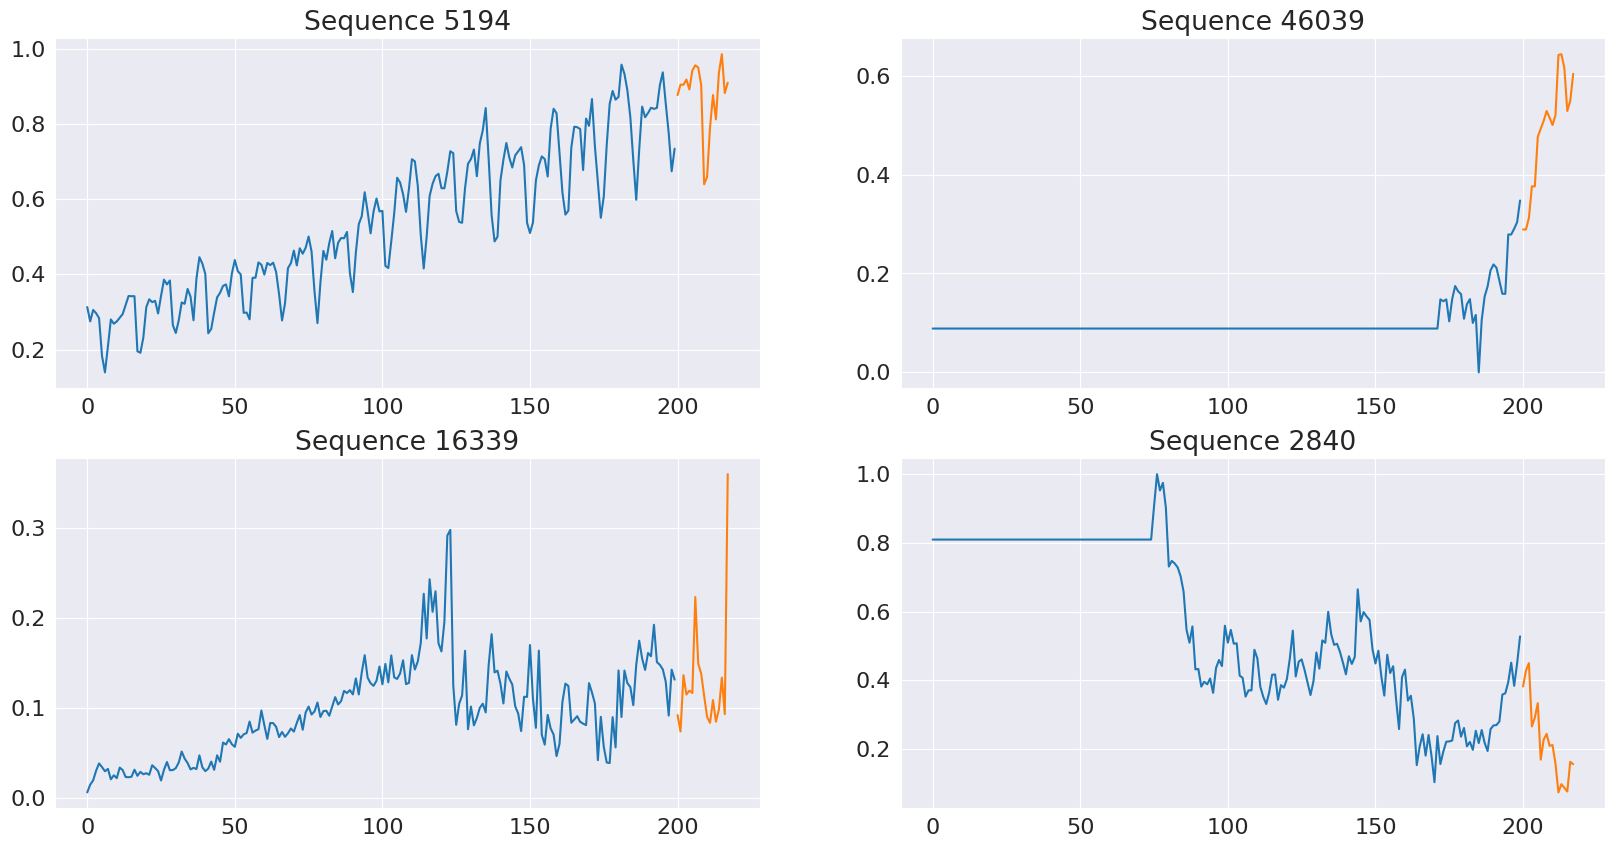

In [68]:
# plot some sequences
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
for i in range(2):
    for j in range(2):
        idx = np.random.randint(0, dataset.shape[0])
        ax[i, j].plot(dataset[idx])
        ax[i, j].plot(np.arange(dataset[idx].shape[0], dataset[idx].shape[0] + labels.shape[1]), labels[idx])
        ax[i, j].set_title("Sequence {}".format(idx))